In [1]:
import numpy as np
import scipy.stats as sts
import scipy.special as spec
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integral
import pandas as pd
import numpy.linalg as lin
%matplotlib notebook

dt = pd.read_csv('usincmoms.txt', delimiter='\t', header = None)
dt.columns = ['percentage','midpoint']

# a. 

In [2]:
#Check the heights of last two bins
dt.head()

,percentage,midpoint
0,0.035190,2500
1,0.041062,7500
2,0.058859,12500
3,0.056836,17500
4,0.058595,22500


In [3]:
#Divide the heights of last two bins by 10 and 20 respectively
weight = dt.percentage.values
weight[40] = weight[40]/10
weight[41] = weight[41]/20
print (weight[40], weight[41])

0.0018970145 0.00115951605


In [4]:
#Convert the unit of dollars into thousand dollars
pts = dt.midpoint.values/1000
pts

array([   2.5,    7.5,   12.5,   17.5,   22.5,   27.5,   32.5,   37.5,
         42.5,   47.5,   52.5,   57.5,   62.5,   67.5,   72.5,   77.5,
         82.5,   87.5,   92.5,   97.5,  102.5,  107.5,  112.5,  117.5,
        122.5,  127.5,  132.5,  137.5,  142.5,  147.5,  152.5,  157.5,
        162.5,  167.5,  172.5,  177.5,  182.5,  187.5,  192.5,  197.5,
        225. ,  300. ])

<IPython.core.display.Javascript object>


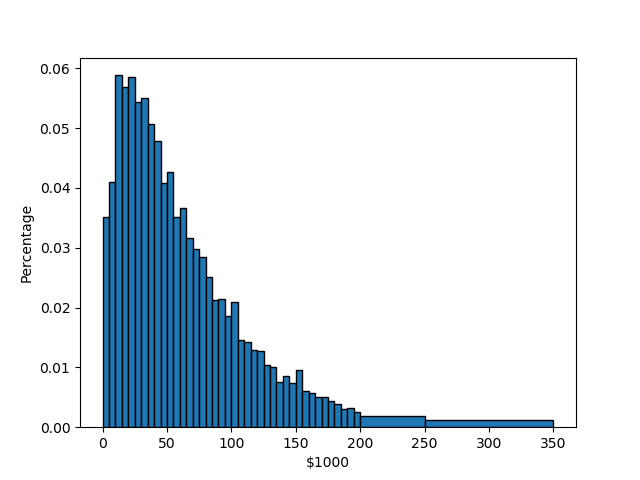

Text(0.5,0,'$1000')

In [5]:
#Re-weighting the bars and plot the histogram
interval = list(range(0,205,5)) + [250,350]
plt.hist(pts, bins = interval, weights = weight, edgecolor = 'black')
plt.ylabel('Percentage')
plt.xlabel('$1000')

# b.

In [6]:
#Construct the pdf of lognormal
def lognorm_pdf(xvals, mu, sigma):
    pdf_vals = np.exp((-(np.log(xvals) - mu)**2) / (2 * sigma**2)) / (xvals * sigma * np.sqrt(2 * np.pi))
    
    return pdf_vals

In [7]:
#Construct the data moment
datamoment = dt.percentage.values
datamoment

array([ 0.03519016,  0.04106206,  0.05885948,  0.05683611,  0.0585952 ,
        0.05443284,  0.0550605 ,  0.05067515,  0.04785894,  0.04083908,
        0.04269728,  0.03509931,  0.03660239,  0.03168022,  0.02978073,
        0.0285089 ,  0.0250733 ,  0.02119173,  0.02142297,  0.01859025,
        0.02086964,  0.01462609,  0.01422967,  0.01295784,  0.01271834,
        0.0103894 ,  0.01000124,  0.00758145,  0.00851468,  0.00737498,
        0.0096296 ,  0.00611141,  0.00575629,  0.00503778,  0.00509559,
        0.00437709,  0.00379898,  0.00299789,  0.00313829,  0.0025767 ,
        0.00189701,  0.00115952])

In [8]:
#Construct the model moment for Lognormal distribution
def model_moment(mu, sigma):
    modelmoment = np.ones(42)
    for i in range(40):
        modelmoment[i] = sts.lognorm.cdf(5*(i+1), sigma, scale = np.exp(mu)) - sts.lognorm.cdf(5*i, sigma, scale = np.exp(mu))
        
    modelmoment[40] = sts.lognorm.cdf(250, sigma, scale = np.exp(mu)) - sts.lognorm.cdf(200, sigma, scale = np.exp(mu))
    modelmoment[41] = sts.lognorm.cdf(350, sigma, scale = np.exp(mu)) - sts.lognorm.cdf(250, sigma, scale = np.exp(mu))
    
    return modelmoment

In [9]:
#Construct weighting matrix
W = np.diag(datamoment)
W

array([[ 0.03519016,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.04106206,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05885948, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.0025767 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00189701,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00115952]])

In [10]:
#Construct error vector
def err_vec(mu, sigma):
    err_vec = model_moment(mu, sigma) - datamoment
    
    return err_vec

In [11]:
#Construct the criterion function
def criterion(params, *args):
    mu, sigma = params
    W = args
    err = err_vec(mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [12]:
mu_init = np.log(np.mean(pts))
sig_init = np.log(np.std(pts))
params_init = np.array([mu_init, sig_init])
W_hat = W
gmm_args = (W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1, ' crit_val=', np.dot(np.dot(err_vec(mu_GMM1, sig_GMM1).T, W), err_vec(mu_GMM1, sig_GMM1)))

mu_GMM1= 3.97482012144  sig_GMM1= 1.04410910538  crit_val= 3.27544396034e-05


<IPython.core.display.Javascript object>


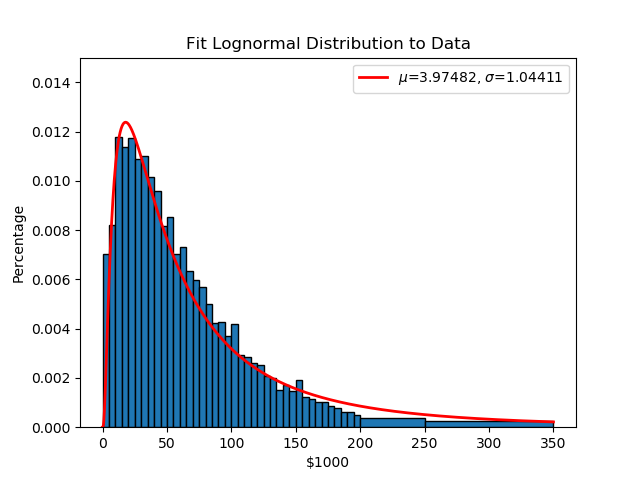

In [14]:
interval = list(range(0,205,5)) + [250,350]
plt.hist(pts, bins = interval, weights = weight/5, edgecolor = 'black')
plt.ylabel('Percentage')
plt.xlabel('$1000')

dist_pts = np.linspace(1e-10, 350, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1), linewidth=2, color='r', label= r'$\mu$=3.97482, $\sigma$=1.04411')
plt.ylim([0,0.015])
plt.title('Fit Lognormal Distribution to Data')
plt.legend(loc='upper right')

# c.

In [15]:
#Construct the pdf for the gamma distribution
def gamma_pdf(xvals, alpha, beta):
    pdf_vals = (1/((beta**alpha) * spec.gamma(alpha))) * (xvals**(alpha-1)) * np.exp(-(xvals/beta))
    
    return pdf_vals

In [16]:
#The data moment is the same as the data moment in part b
datamoment

array([ 0.03519016,  0.04106206,  0.05885948,  0.05683611,  0.0585952 ,
        0.05443284,  0.0550605 ,  0.05067515,  0.04785894,  0.04083908,
        0.04269728,  0.03509931,  0.03660239,  0.03168022,  0.02978073,
        0.0285089 ,  0.0250733 ,  0.02119173,  0.02142297,  0.01859025,
        0.02086964,  0.01462609,  0.01422967,  0.01295784,  0.01271834,
        0.0103894 ,  0.01000124,  0.00758145,  0.00851468,  0.00737498,
        0.0096296 ,  0.00611141,  0.00575629,  0.00503778,  0.00509559,
        0.00437709,  0.00379898,  0.00299789,  0.00313829,  0.0025767 ,
        0.00189701,  0.00115952])

In [17]:
#Construct the model moment for the gamma distribution
def model_momentGA(alpha, beta):
    modelmomentGA = np.ones(42)
    for i in range(40):
        modelmomentGA[i] = sts.gamma.cdf(5*(i+1), alpha, scale = beta) - sts.gamma.cdf(5*i, alpha, scale = beta)
        
    modelmomentGA[40] = sts.gamma.cdf(250, alpha, scale = beta) - sts.gamma.cdf(200, alpha, scale = beta)
    modelmomentGA[41] = sts.gamma.cdf(350, alpha, scale = beta) - sts.gamma.cdf(250, alpha, scale = beta)
    
    return modelmomentGA

In [18]:
#Construct error vector
def err_vecGA(alpha, beta):
    err_vec = model_momentGA(alpha, beta) - datamoment
    
    return err_vec

In [19]:
#Construct the criterion function
def criterionGA(params, *args):
    alpha, beta = params
    W = args
    err = err_vecGA(alpha, beta)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [20]:
W

array([[ 0.03519016,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.04106206,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05885948, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.0025767 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00189701,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00115952]])

In [21]:
alpha_init = 3.0
beta_init = 20.0
params_init = np.array([alpha_init, beta_init])
W_hat = W
gmm_args = (W_hat)
results = opt.minimize(criterionGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1, ' crit_val=', np.dot(np.dot(err_vecGA(alpha_GMM1, beta_GMM1).T, W), err_vecGA(alpha_GMM1, beta_GMM1)))

alpha_GMM1= 1.43546027378  beta_GMM1= 44.1948670575  crit_val= 6.63023827911e-06


<IPython.core.display.Javascript object>


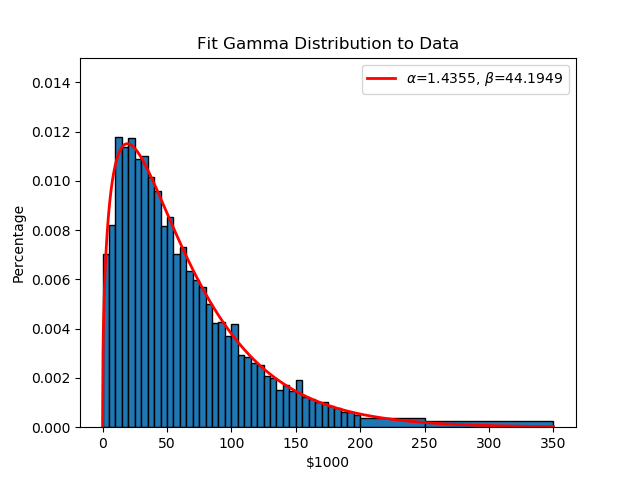

In [22]:
plt.hist(pts, bins = interval, weights = weight/5, edgecolor = 'black')
plt.ylabel('Percentage')
plt.xlabel('$1000')

dist_pts = np.linspace(1e-10, 350, 1000)
plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_GMM1, beta_GMM1), linewidth=2, color='r', label= r'$\alpha$=1.4355, $\beta$=44.1949')
plt.ylim([0,0.015])
plt.title('Fit Gamma Distribution to Data')
plt.legend(loc='upper right')

# d.

<IPython.core.display.Javascript object>


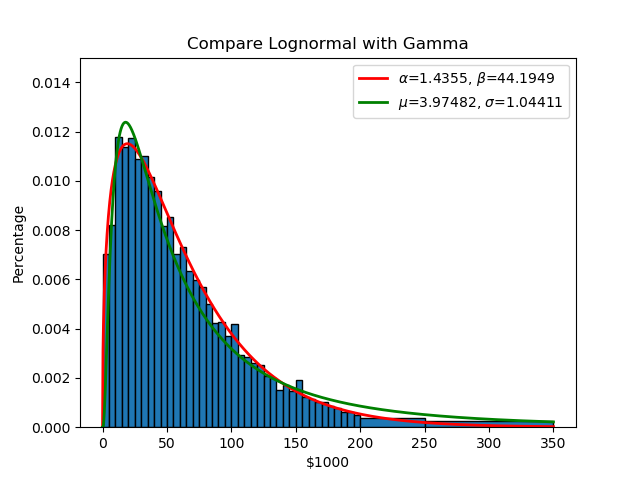

In [23]:
plt.hist(pts, bins = interval, weights = weight/5, edgecolor = 'black')
plt.ylabel('Percentage')
plt.xlabel('$1000')

dist_pts = np.linspace(1e-10, 350, 1000)
plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_GMM1, beta_GMM1), linewidth=2, color='r', label= r'$\alpha$=1.4355, $\beta$=44.1949')
plt.legend(loc='upper right')

plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1), linewidth=2, color='g', label= r'$\mu$=3.97482, $\sigma$=1.04411')
plt.ylim([0,0.015])
plt.title('Compare Lognormal with Gamma')
plt.legend(loc='upper right')

### By comparing the two lines, we can see that the gamma distribution is a better fit than the lognormal distribution. By comparing the values of two criterion functions, we can also see that the value of the criterion function of the gamma distribution is smaller than that of lognormal distribution which implies the gamma distribution is a better fit.

# e.

In [24]:
#Since we want to use the two-step estimator, then we first estimate the
# parameters by using the Identity Matrix
W_Id = np.eye(42)

In [25]:
alpha_init = 3.0
beta_init = 20.0
params_init = np.array([alpha_init, beta_init])
W_hat = W_Id
gmm_args = (W_hat)
results = opt.minimize(criterionGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMMID, beta_GMMID = results.x
print('alpha_GMMID=', alpha_GMMID, ' beta_GMMID=', beta_GMMID, ' crit_val=', np.dot(np.dot(err_vecGA(alpha_GMMID, beta_GMMID).T, W_Id), err_vecGA(alpha_GMMID, beta_GMMID)))

alpha_GMMID= 1.48127363474  beta_GMMID= 41.2944899057  crit_val= 0.000383571896807


In [26]:
#Now we use the results above to compute the new weighting matrix
VCV2 = np.outer(err_vecGA(alpha_GMMID, beta_GMMID), err_vecGA(alpha_GMMID, beta_GMMID)) / pts.shape[0]
W_New = lin.pinv(VCV2)
W_New

array([[  4.79233157e+03,  -1.02052527e+04,   2.58264666e+03, ...,
          1.69221892e+02,  -1.41196346e+04,  -5.75435137e+03],
       [ -1.02052527e+04,   2.17320485e+04,  -5.49973669e+03, ...,
         -3.60357405e+02,   3.00677107e+04,   1.22538704e+04],
       [  2.58264666e+03,  -5.49973669e+03,   1.39182018e+03, ...,
          9.11957673e+01,  -7.60924545e+03,  -3.10109102e+03],
       ..., 
       [  1.69221892e+02,  -3.60357405e+02,   9.11957673e+01, ...,
          5.97538970e+00,  -4.98578040e+02,  -2.03191748e+02],
       [ -1.41196346e+04,   3.00677107e+04,  -7.60924545e+03, ...,
         -4.98578040e+02,   4.16006444e+04,   1.69540312e+04],
       [ -5.75435137e+03,   1.22538704e+04,  -3.10109102e+03, ...,
         -2.03191748e+02,   1.69540312e+04,   6.90948847e+03]])

In [29]:
#Using the new weighting matrix to re-estimate GMM estimator
alpha_init = 1.4
beta_init = 41.2
params_init = np.array([alpha_init, beta_init])
W_hat = W_New
gmm_args = (W_hat)
results = opt.minimize(criterionGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMMTS, beta_GMMTS = results.x
print('alpha_GMMTS=', alpha_GMMTS, ' beta_GMMTS=', beta_GMMTS, ' crit_val=', np.dot(np.dot(err_vecGA(alpha_GMMTS, beta_GMMTS).T, W_New), err_vecGA(alpha_GMMTS, beta_GMMTS)))

alpha_GMMTS= 0.835376585852  beta_GMMTS= 41.2423111381  crit_val= -2.03427666454e-14


# The $\alpha$ changes a bit but $\beta$ does not change. We can use the graph and the values of criterion functions to identify which is a better fit

# 2

In [30]:
TSdt = pd.read_csv('MacroSeries.txt', header = None)
TSdt.columns = ['c','k','w','r']
TSdt.head()

,c,k,w,r
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


In [31]:
#Firstly, use w, k, alpha, and equation (4) to express z.
def get_z(k, r, alpha):
    z = np.log(r) - np.log(alpha) - (alpha - 1)*np.log(k)
    
    return z

In [32]:
#Compute the data moment
def data_moment(c, k, w, r, alpha, beta, rho, mu):
    datamoment = np.ones(4)
    x = np.ones(99)
    y = np.ones(99)
    u = np.ones(99)
    v = np.ones(99)
    z = get_z(k, r, alpha)
    for i in range(99):
        x[i] = z[i+1] - rho*z[i] - (1 - rho)*mu
    
    for i in range(99):
        y[i] = (z[i+1] - rho*z[i] - (1 - rho)*mu) * z[i]
        
    for i in range(99):
        u[i] = beta*alpha*np.exp(z[i+1])*((k[i+1])**(alpha - 1))*(c[i]/c[i+1]) - 1
        
    for i in range(99):
        v[i] = (beta*alpha*np.exp(z[i+1])*((k[i+1])**(alpha - 1))*(c[i]/c[i+1]) - 1) * w[i]
        
    datamoment[0] = x.sum() / 99
    datamoment[1] = y.sum() / 99
    datamoment[2] = u.sum() / 99
    datamoment[3] = v.sum() / 99
    
    return datamoment

In [33]:
#Compute the error vector
def err_vec(c, k, w, r, alpha, beta, rho, mu):
    err_vec = data_moment(c, k, w, r, alpha, beta, rho, mu)
    
    return err_vec

In [34]:
#Compute the criterion function
def criterion(params, *args):
    alpha, beta, rho, mu = params
    c, k, w, r, M = args
    err = err_vec(c, k, w, r, alpha, beta, rho, mu)
    crit_val = np.dot(np.dot(err.T, M), err)
    
    return crit_val

In [35]:
c = TSdt.c.values
k = TSdt.k.values
w = TSdt.w.values
r = TSdt.r.values
M = np.eye(4)

In [36]:
alpha_init = 0.3
beta_init = 0.9
rho_init = 0.8
mu_init = 12.3
params_init = np.array([alpha_init, beta_init, rho_init, mu_init])
M_hat = M
gmm_args = (c, k, w, r, M_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, 1 - 1e-10), (1e-10, 1 - 1e-10), (1e-10 - 1, 1 - 1e-10), (1e-10, None)))
alpha_GMM, beta_GMM, rho_GMM, mu_GMM = results.x
print ('alpha_GMM=', alpha_GMM, ' beta_GMM=', beta_GMM, ' rho_GMM=', rho_GMM, ' mu_GMM=', mu_GMM, ' crit=', np.dot(np.dot(err_vec(c, k, w, r, alpha_GMM, beta_GMM, rho_GMM, mu_GMM).T, M), err_vec(c, k, w, r, alpha_GMM, beta_GMM, rho_GMM, mu_GMM)))

alpha_GMM= 0.299291599775  beta_GMM= 0.989999995002  rho_GMM= 0.826611792027  mu_GMM= 12.3009440833  crit= 0.00276513212259
